# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写



In [1]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm.notebook import tqdm
import random
from collections import defaultdict
import math

In [2]:
#参数配置

config = {
    "behaviour_path":'Amazon_Electronics.inter',
    "item_path":'Amazon_Electronics.item',
    "debug_mode" : True,
    "epoch" : 5,
    "batch" : 2048,
    "lr" : 0.001,
    "device" : 1,
}

In [3]:
df = pd.read_csv(config['behaviour_path'],sep='\t')
df = df.rename(columns={k:k.split(':')[0] for k in df.columns})

In [5]:
pos_df = df[df['rating']>=3].reset_index(drop=True)

# 对DataFrame里面某一列的操作方法

# map : 使用map方法，需要传入一个k:v对，这里的k需要时改列的所有值，v是映射后的值
# apply : 使用apply方法需要传入一个函数，这个函数里面需要定义对一个值的操作逻辑
pos_df['user_count'] = pos_df['user_id'].map(pos_df['user_id'].value_counts())
pos_df = pos_df[pos_df['user_count']>5].reset_index(drop=True)
pos_df = pos_df.sort_values(by=['user_id','timestamp'],ascending=True)

In [6]:
df.shape,pos_df.shape

((7824482, 4), (1526459, 5))

In [12]:
eval(item_df['categories'].iloc[0])

('Cables & Accessories',
 'Electronics',
 'Computers & Accessories',
 'Monitor Accessories')

In [13]:
item_df = pd.read_csv(config['item_path'],sep='\t')
item_df = item_df.rename(columns={k:k.split(':')[0] for k in item_df.columns})

item_df['categories'] = item_df['categories'].apply(lambda x: eval(x)[-1])
# def map_fun(x):
#     return eval(x)[-1]

cate_map_dict = dict(zip(item_df['categories'].unique(),range(1,item_df['categories'].nunique()+1)))
item_df['categories'] = item_df['categories'].map(cate_map_dict)

In [14]:
pos_df = pos_df.merge(item_df[['item_id','categories']],on='item_id',how='left').reset_index(drop=True)

In [15]:
item_map_dict = dict(zip(pos_df['item_id'].unique(),range(1,pos_df['item_id'].nunique()+1)))
pos_df['item_id'] = pos_df['item_id'].map(item_map_dict)

In [16]:
user_map_dict = dict(zip(pos_df['user_id'].unique(),range(1,pos_df['user_id'].nunique()+1)))
pos_df['user_id'] = pos_df['user_id'].map(user_map_dict)

In [18]:
pos_dict = pos_df.groupby('user_id')['item_id'].apply(list).to_dict()

In [19]:
# 序列长度
max_seq = 20
# 负采样
ratio = 2
# 构造样本
label_list = []
user_list = []

item_list = []
cate_list = []

item_seq_list = []
cate_seq_list = []

if config['debug_mode']:
    all_user_list = pos_df['user_id'].unique()[:1000]
else:
    all_user_list = pos_df['user_id'].unique()
    
all_item_list = pos_df['item_id'].unique()
item_num = pos_df['item_id'].nunique()

# 获取item2cate的映射
data = pos_df[['item_id', 'categories']]
item2attr = data.set_index(['item_id'])['categories'].to_dict()
# update:{0:0} 对序列中补0的item，将其categories也设置成0
item2attr.update({0:0})


for user in tqdm(all_user_list):
    # 正样本
    for i in range(len(pos_dict[user])-5,len(pos_dict[user])-1):
        user_list.append(user)
        item_list.append(pos_dict[user][i+1])
        cate_list.append(item2attr[pos_dict[user][i+1]])
        label_list.append(1)
        
        if i < max_seq:
            item_seq = pos_dict[user][:i] + [0]*(max_seq-i)
        else:
            item_seq = pos_dict[user][i-max_seq:i]
        
        cate_seq = [item2attr[item] for item in item_seq]
        
        item_seq_list.append(item_seq)
        cate_seq_list.append(cate_seq)
        
        for i in range(ratio):
            user_list.append(user)
            label_list.append(0)
            item_seq_list.append(item_seq)
            cate_seq_list.append(cate_seq)
            
            # 为了防止 负采样选出来的Item 在用户的正向历史行为序列(pos_dict)当中
            temp_item_index = random.randint(0, item_num - 1)
            while all_item_list[temp_item_index] in pos_dict[user]:
                temp_item_index = random.randint(0, item_num - 1)
            item_list.append(all_item_list[temp_item_index])
            cate_list.append(item2attr[all_item_list[temp_item_index]])
        
df = pd.DataFrame()
df['user_id'] = user_list
df['target_item_id'] = item_list
df['hist_item_id'] = item_seq_list
df['target_categories'] = cate_list
df['hist_categories'] = cate_seq_list
df['label'] = label_list

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# hold out 切分数据集
df = df.sample(frac=1).reset_index(drop=True)

train_num = int(len(df)*0.8)
valid_num = int(len(df)*0.1)

train_df = df[:train_num].reset_index(drop=True)
valid_df = df[train_num:train_num+valid_num].reset_index(drop=True)
test_df = df[train_num+valid_num:].reset_index(drop=True)

In [21]:
train_df.shape,valid_df.shape,test_df.shape

((9600, 6), (1200, 6), (1200, 6))

In [22]:
train_df.head()

,user_id,target_item_id,hist_item_id,target_categories,hist_categories,label
0,298,110662,"[2759, 2760, 2761, 2762, 2763, 2764, 0, 0, 0, ...",81,"[183, 67, 233, 67, 129, 21, 0, 0, 0, 0, 0, 0, ...",0
1,211,64576,"[1939, 1940, 1941, 1382, 0, 0, 0, 0, 0, 0, 0, ...",13,"[25, 10, 54, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,412,3800,"[3785, 3597, 1453, 3786, 3787, 3788, 515, 3789...",13,"[3, 23, 61, 94, 16, 16, 69, 16, 61, 33, 100, 2...",1
3,123,203738,"[1180, 1181, 1182, 1183, 1184, 1185, 1186, 118...",25,"[90, 190, 21, 33, 54, 64, 5, 55, 0, 0, 0, 0, 0...",0
4,303,7868,"[2812, 2813, 766, 1998, 2086, 2814, 2815, 0, 0...",26,"[47, 13, 37, 5, 23, 81, 3, 0, 0, 0, 0, 0, 0, 0...",0


## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O




In [23]:
enc_dict = defaultdict(dict)
enc_dict['user_id'] = {
    'vocab_size':len(user_map_dict)+1,
    'type':'user'
}
enc_dict['target_item_id'] = {
    'vocab_size':len(item_map_dict)+1,
    'type':'item'
}
enc_dict['target_categories'] = {
    'vocab_size':len(cate_map_dict)+1,
    'type':'item'
}
# 对于序列特征，我们不需要对其单独进行构造embedding表，只需要和item侧的embedding进行共享即可
enc_dict['hist_item_id'] = {
    'share_with':'target_item_id',
    'type':'item'
}
enc_dict['hist_categories'] = {
    'share_with':'target_categories',
    'type':'item'
}

In [24]:
#Dataset构造
class DINDataset(Dataset):
    def __init__(self,config,df,enc_dict=None):
        self.config = config
        self.df = df
        self.enc_dict = enc_dict
        self.sparse_cols = ['user_id','target_item_id','target_categories']
        self.seq_cols = ['hist_item_id','hist_categories']
        self.feature_name = self.sparse_cols+self.seq_cols+['label']
        
        self.enc_data()

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_data_dict = defaultdict(np.array)
        
        for col in self.sparse_cols:
            self.enc_data_dict[col] = torch.Tensor(np.array(self.df[col].values)).long()
            
        for col in self.seq_cols:
            self.enc_data_dict[col] = torch.Tensor(np.array(self.df[col].values.tolist())).long()

    def __getitem__(self, index):
        data = defaultdict(np.array)
        for col in self.seq_cols:
            data[col] = self.enc_data_dict[col][index]
        for col in self.sparse_cols:
            data[col] = self.enc_data_dict[col][index]
        if 'label' in self.df.columns :
            data['label'] = torch.Tensor([self.df['label'].iloc[index]]).squeeze(-1)
        return data

    def __len__(self):
        return len(self.df)

In [25]:
train_dataset = DINDataset(config,train_df,enc_dict=enc_dict)
valid_dataset = DINDataset(config,valid_df,enc_dict=enc_dict)
test_dataset = DINDataset(config,test_df,enc_dict=enc_dict)

In [27]:
test_dataset.__getitem__(666)

defaultdict(<function numpy.array>,
            {'hist_item_id': tensor([2818, 2819,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0]),
             'hist_categories': tensor([23, 70,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                      0,  0]),
             'user_id': tensor(304),
             'target_item_id': tensor(184236),
             'target_categories': tensor(28),
             'label': tensor(0.)})

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

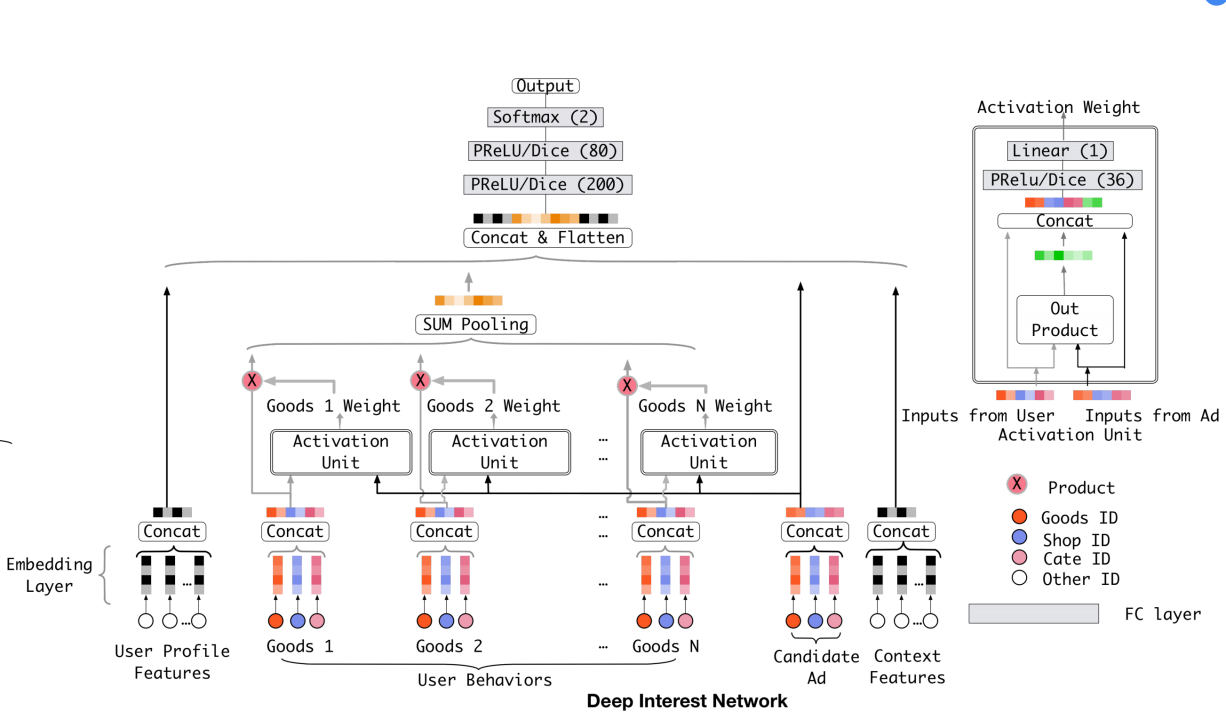

### 实现DIN注意的四点
* 1.实现一个可以支持Embeeding表贡献的Embedding Layer
* 2.实现DIN Attention，这里要注意向量化的思维模式
* 3.实现Dice，理解Dice的公式转换逻辑
* 4.实现Mini-Batch Aware Regularization

In [28]:
# 带有共享Embedding表的Embedding Layer
class EmbeddingLayer(nn.Module):
    def __init__(self,embedding_dim,enc_dict):
        super(EmbeddingLayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.enc_dict = enc_dict
        
        self.query_cols = []
        self.his_cols = []
        self.user_cols = []
        
        self.emb_layer = nn.ModuleDict()
        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col]:
                if self.enc_dict[col]['type']=='item':
                    self.query_cols.append(col)
                    self.emb_layer.update({
                        col : nn.Embedding(self.enc_dict[col]['vocab_size'],
                                          self.embedding_dim,
                                          padding_idx=0)})
                else:
                    self.user_cols.append(col)
                    self.emb_layer.update({
                        col : nn.Embedding(self.enc_dict[col]['vocab_size'],
                                          self.embedding_dim,
                                          padding_idx=0)})
            else:
                self.his_cols.append(col)
                
    def forward(self,data):
        query_emb_list = []
        his_emb_list = []
        user_emb_list = []
        for col in self.query_cols:
            query_emb_list.append(self.emb_layer[col](data[col]))
        query_emb = torch.cat(query_emb_list,dim=1).squeeze(1) # [batch,embx2]
        
        for col in self.his_cols:
            his_emb_list.append(self.emb_layer[self.enc_dict[col]['share_with']](data[col]))
        his_emb = torch.cat(his_emb_list,dim=-1)# [batch,max_seq,embx2]
        
        for col in self.user_cols:
            user_emb_list.append(self.emb_layer[col](data[col]))
        user_emb = torch.cat(user_emb_list,dim=1).squeeze(1) # [batch,emb]
        return user_emb, query_emb, his_emb

# DIN Attention   
class DINAttentionLayer(nn.Module):
    def __init__(self,
                 embedding_dim=64,
                 attention_units=[32],
                 hidden_activations="Dice",
                 final_activation=None,
                 dice_alpha=0.,
                 dropout_rate=0,
                 batch_norm=False):
        super(DINAttentionLayer, self).__init__()
        self.embedding_dim = embedding_dim
        if isinstance(hidden_activations, str) and hidden_activations.lower() == "dice":
            hidden_activations = [Dice(units, alpha=dice_alpha) for units in attention_units]
        self.attention_layer = MLP_Layer(input_dim=4 * embedding_dim, # 作者的代码和论文稍有出入
                                         output_dim=1,
                                         hidden_units=attention_units,
                                         hidden_activations=hidden_activations,
                                         final_activation=final_activation,
                                         dropout_rates=dropout_rate,
                                         batch_norm=batch_norm,
                                         use_bias=True)
    def get_mask(self,history_sequence):
        # 返回序列中的mask
        return (history_sequence > 0).sum(-1) # 1是有效数据，0是无效数据
        
    def forward(self, query_item, history_sequence):
        # query_item: [batch , emd]
        # history_sequence: [batch , seq_len , emb]
        mask = self.get_mask(history_sequence) # [batch,seq_len]
        seq_len = history_sequence.size(1)
        
        query_item = query_item.unsqueeze(1).expand(-1, seq_len, -1) # [batch,seq_len,4xemb]
        attention_input = torch.cat([query_item, history_sequence, query_item - history_sequence,
                                     query_item * history_sequence], dim=-1) # [batch,seq_len,4xemb]
        attention_weight = self.attention_layer(attention_input.view(-1, 4 * self.embedding_dim))
        attention_weight = attention_weight.view(-1, seq_len) #[batch , seq_len]
        attention_weight = attention_weight * mask.float() # mask by all zeros
        output = (attention_weight.unsqueeze(-1) * history_sequence).sum(dim=1) #[batch,emb]
        return output
    
#MLP
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_faeture_num(enc_dict):
    num_user = 0
    num_item = 0
    for col in enc_dict.keys():
        if 'vocab_size' in enc_dict[col].keys():
            if enc_dict[col]['type']=='item':
                num_item +=1
            else:
                num_user +=1
    return num_user,num_item

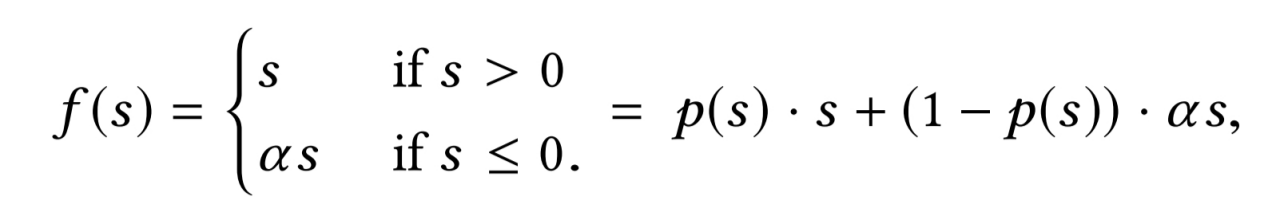
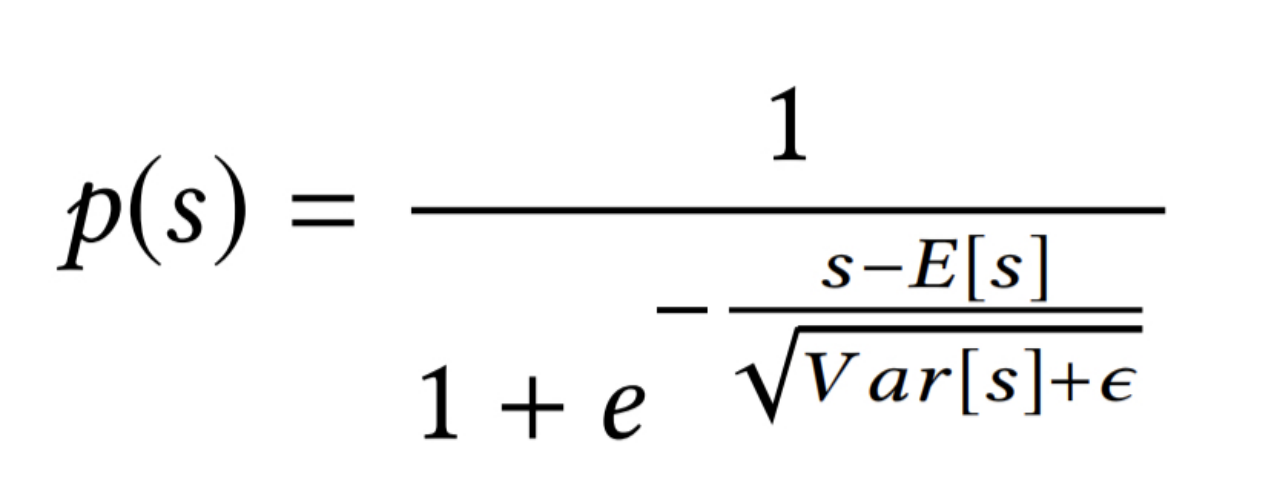

In [29]:
class Dice(nn.Module):
    def __init__(self, input_dim, alpha=0., eps=1e-8):
        super(Dice, self).__init__()
        self.bn = nn.BatchNorm1d(input_dim, eps=eps)
        self.alpha = nn.Parameter(torch.tensor(alpha), requires_grad=False)

    def forward(self, X):
        '''
        第一步：计算控制函数p(s)
            （a）:走一个batchnorm
            （b）:对batchnorm的结果走一个sigmoid
        第二部：根据控制函数p(s)，完成最终计算逻辑
        '''
        p = torch.sigmoid(self.bn(X))
        output = p * X + (1 - p) * self.alpha * X
        return output

In [30]:
# DIN模型
class DIN(nn.Module):
    def __init__(self,
                 hidden_units=[64, 32, 16],
                 attention_units=[32],
                 embedding_dim=10,
                 loss_fun='torch.nn.BCELoss()',
                 enc_dict=None,
                 count_map = None):

        super(DIN, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.attention_units = attention_units
        self.loss_fun = eval(loss_fun)
        self.enc_dict = enc_dict
        self.count_map = count_map

        self.embedding_layer = EmbeddingLayer(enc_dict=self.enc_dict, embedding_dim=self.embedding_dim)

        self.num_user, self.num_item = get_faeture_num(enc_dict)

        self.din_att = DINAttentionLayer(embedding_dim=self.embedding_dim*self.num_item,
                                         attention_units=self.attention_units)

        self.mlp = MLP_Layer(input_dim=self.embedding_dim * (2*self.num_item+self.num_user),
                             hidden_units=self.hidden_units, output_dim=1)
    
    def MBA_Reg(self,data,col):
        feature_id = torch.unique(data[col]) # 获取去重之后的ID
        feature_emb_list = []
        for f in feature_id:
            feature_emb_list.append(self.embedding_layer.emb_layer[col](f)**2 / self.count_map[col][int(f.detach().cpu().numpy())])
        feature_emb = torch.cat(feature_emb_list,dim=0).mean(0)
        return feature_emb.mean() # 1
    
    def l2_reg(self,data):
        user_mba_l2 = self.MBA_Reg(data,'user_id')
        item_mba_l2 = self.MBA_Reg(data,'target_item_id')
        cate_mba_l2 = self.MBA_Reg(data,'target_categories')
        
        mba_l2 = user_mba_l2 + item_mba_l2 + cate_mba_l2
        return mba_l2

    def forward(self, data):

        user_emb, query_emb, his_item_emb = self.embedding_layer(data)

        din_out = self.din_att(query_emb, his_item_emb) # [batch,emb*2]
        
        mlp_input = torch.cat([user_emb, din_out, query_emb],dim=-1)
        mlp_out = self.mlp(mlp_input)
        y_pred = torch.sigmoid(mlp_out)
        
        loss = self.loss_fun(y_pred.squeeze(-1), data['label']) + 0.2*self.l2_reg(data)
        output_dict = {'pred': y_pred, 'loss': loss}

        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [31]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def get_test_predict(model, test_loader, device):
    model.eval()
    pred_list = []

    for data in tqdm(test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())

    return pred_list

In [32]:
#dataloader
#num_workers:多线程取batch数据，⚠️在win的notebook下，num_workers只能取0，不然会有意外的bug
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=0)
valid_loader = D.DataLoader(valid_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

In [33]:
count_map = defaultdict(dict)
count_map['user_id'] = pos_df['user_id'].value_counts().to_dict()
count_map['target_item_id'] = pos_df['item_id'].value_counts().to_dict()
count_map['target_categories'] = pos_df['categories'].value_counts().to_dict()

In [34]:
model = DIN(enc_dict=enc_dict,count_map=count_map)

In [35]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)
    
    valid_metirc = valid_model(model,valid_loader,device=device)

    print(f"Epoch {i+1} Train Metric:")
    print(train_metirc)
    
    print(f"Epoch {i+1} Valid Metric:")
    print(valid_metirc)
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 Train Metric:
{'roc_auc_score': 0.5067281781187329, 'log_loss': 0.6525141949051371}
Epoch 1 Valid Metric:
{'roc_auc_score': 0.5336457839962109, 'log_loss': 0.6343238360496859}


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Train Metric:
{'roc_auc_score': 0.51565141942016, 'log_loss': 0.644051356050962}
Epoch 2 Valid Metric:
{'roc_auc_score': 0.5370428448904875, 'log_loss': 0.6273773973450686}


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Train Metric:
{'roc_auc_score': 0.5287946124340427, 'log_loss': 0.6404265628649348}
Epoch 3 Valid Metric:
{'roc_auc_score': 0.5342234283592979, 'log_loss': 0.6271317488203446}


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 Train Metric:
{'roc_auc_score': 0.5418676132712864, 'log_loss': 0.6369307744241087}
Epoch 4 Valid Metric:
{'roc_auc_score': 0.5284085817790806, 'log_loss': 0.6278387331124395}


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 Train Metric:
{'roc_auc_score': 0.5535007739636675, 'log_loss': 0.6343871234962717}
Epoch 5 Valid Metric:
{'roc_auc_score': 0.527240492069791, 'log_loss': 0.6274986309496065}
Test Metric:
{'roc_auc_score': 0.525465544681011, 'log_loss': 0.6367556493077428}


In [36]:
y_pre = get_test_predict(model,test_loader,device)
test_df['y_pre'] = y_pre

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
test_df['ranking'] = test_df.groupby(['user_id'])['y_pre'].rank(method='first', ascending=False)

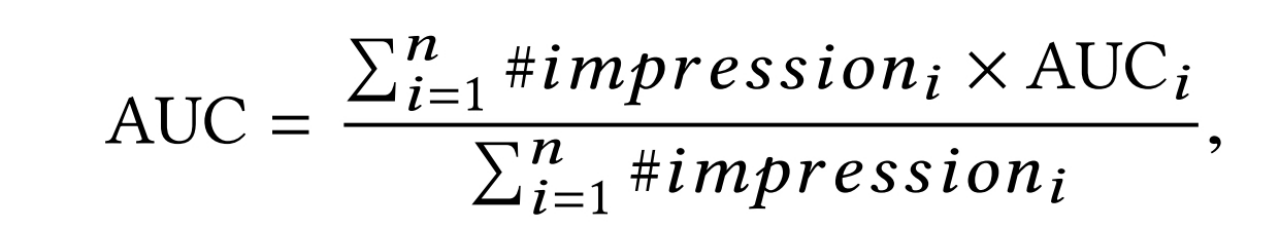

In [40]:
def gauc(df,user_col,label_col,pre_col):
    '''
    分别计算分子和分母
    '''
    preds = df.groupby(user_col)[pre_col].apply(list).to_dict()
    labels = df.groupby(user_col)[label_col].apply(list).to_dict()
    count_user = 0
    count_auc = 0
    for u in preds.keys():
        if np.sum(labels[u])==0 or np.sum(labels[u])==len(labels[u]):
            # labels 里面全是1或者全是0，无法计算auc
            continue
        count_auc += len(labels[u]) * roc_auc_score(labels[u],preds[u])
        count_user += len(labels[u])
    return count_auc / count_user
        

In [41]:
gauc(test_df,'user_id','label','y_pre')

0.5712890625

In [49]:
model.embedding_layer.emb_layer['user_id'].weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8395,  0.0159, -1.9611,  ...,  1.6770, -0.2308,  0.0321],
        [-1.2321, -0.5999, -0.7647,  ..., -0.2242,  0.8443, -0.2434],
        ...,
        [-0.3725, -0.0786, -2.5326,  ..., -0.5613, -0.3929,  0.0506],
        [-0.8953, -1.2238,  0.1161,  ..., -1.8372, -0.4445,  0.4451],
        [-0.2336,  0.1161,  0.8425,  ...,  0.3991,  1.6622, -0.0759]],
       device='cuda:1', requires_grad=True)